In [1]:
echo "# LocalVol_Vega2023" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/vovancheek/LocalVol_Vega2023.git
git push -u origin main

SyntaxError: invalid syntax (2470913961.py, line 1)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy.stats as sps
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
from scipy.interpolate import CubicSpline, UnivariateSpline, RectBivariateSpline
import heston
import blackscholes   # добавила
import blackscholes_t10

warnings.filterwarnings('ignore')

In [2]:
#r = 0.05
r = 0.
initial_price = 80

myheston = heston.Heston(s=initial_price, v=1, kappa=1, theta=0.4, sigma=0.4, rho=0.5, r=r)
mybsch = blackscholes.BlackScholes(s=initial_price, sigma=0.4, r=r)  # добавила

T_grid = np.linspace(0.2, 1, 7)
K_grid = np.linspace(60, 140, 10)

#call_prices = myheston.call_price(T_grid.reshape(-1, 1), K_grid)
#implied_volatilities = myheston.iv(T_grid.reshape(-1, 1), K_grid)

# изменила
call_prices = mybsch.call_price(T_grid.reshape(-1, 1), K_grid)
implied_volatilities = mybsch.call_iv(call_prices, T_grid.reshape(-1, 1), K_grid)


In [3]:
class LocalVolatility:
    
    def __init__(self, r, initial_price):
        self.r = r
        self.initial_price = initial_price

    
    def set_new_coordinates(self, iv, K_grid, T_grid):

        self.y = np.log(np.repeat(K_grid.reshape(1, -1), len(T_grid), axis=0)) - np.log(self.initial_price)
        self.t = np.repeat(T_grid.reshape(1, -1), len(K_grid), axis=0).T 
        
    def get_new_coordinates(self):
        return self.y, self.t
    

    def get_p_right(self, call_prices, K_grid, i):
        dK = K_grid[1] - K_grid[0]
        d2C_dK = 1 / dK / dK * (call_prices[i, 2:] - 2 * call_prices[i, 1:-1] + call_prices[i, :-2]) 
        p = 0.
        integral = 0
        n = 1000
        step = 0
        
        while (integral < 1e+10) & (step < n): 
            integral = np.sum(d2C_dK * np.power(K_grid[1:-1], p+1)) * dK    # формула трапеций
            p += 0.01
            step += 1
            
        if (step == n):
            p = 1e10
            
        return p
    
    def get_p_left(self, call_prices, K_grid, i):
        dK = K_grid[1] - K_grid[0]
        d2C_dK = 1 / dK / dK * (call_prices[i, 2:] - 2 * call_prices[i, 1:-1] + call_prices[i, :-2]) 
        p = 0.
        integral = 0
        n = 1000
        step = 0
        
        
        while (integral < 1e+10) & (step < n):
            integral = np.sum(d2C_dK * np.power(K_grid[1:-1], -p)) * dK     # формула трапеций
            p += 0.01
            step +=1
            #print(integral)
        
        if (step == n):
            p = 1e10
        
        return p
            
        
    def set_extended_grid(self, iv, y, t, N = 500, M = 500, gamma = 1):
        #print(y)
        #print(t)
        w = t * np.square(iv)
        ind = np.argmin(np.abs(np.log(y)))
        ATM_iv = iv[:, ind] # BS implied vol of ATM market options
        D = gamma * np.mean(ATM_iv) * np.sqrt(np.max(w))

        y_values = np.linspace(-D, D, N + 1)
        t_values = np.linspace(np.min(t), np.max(t), M + 1)

        self.y_extended, self.t_extended = np.meshgrid(y_values, t_values)
        
    def get_extended_grid(self):
        return self.y_extended, self.t_extended
    
    def make_implied_volatility_surface(self, iv, K_grid, T_grid, y, t, y_extended, t_extended):
        
        w_init = t * np.square(iv)
        w = np.zeros_like(y_extended)
        dw_dy = np.zeros_like(y_extended)
        dw_dT = np.zeros_like(y_extended)
        d2w_dy = np.zeros_like(y_extended)
        y_min = np.min(y)
        y_max = np.max(y)
        j_min = np.argmin(np.abs(y_extended[0] - y_min))   # тот индекс, начиная с которого работает интерполяция
        j_max = np.argmin(np.abs(-y_extended[0] + y_max))  # тот индекс, на котором перестает работать интерполяция
        if (y_extended[0, j_min] < y_min) & (j_min < len(y_extended[0]) - 1 ):
            j_min += 1
        if (y_extended[0, j_max] > y_max) & (j_max > 0):
            j_max -= 1

        
        tmp = np.zeros((len(T_grid), y_extended.shape[1]))
        tmp1 = np.zeros((len(T_grid), y_extended.shape[1]))
        tmp2 = np.zeros((len(T_grid), y_extended.shape[1]))
        
        a = np.ones(len(T_grid))
        b = np.ones(len(T_grid))

        # iterate over time
        for i in range(len(T_grid)):
            
            spline = CubicSpline(y[i], w_init[i], bc_type='natural')

            tmp[i, j_min:(j_max+1)] = spline(y_extended[i, j_min:(j_max+1)])
            tmp1[i, j_min:(j_max+1)] = spline.derivative(nu=1)(y_extended[i, j_min:(j_max+1)])
            tmp2[i, j_min:(j_max+1)] = spline.derivative(nu=2)(y_extended[i, j_min:(j_max+1)])
            
            q = self.get_p_left(call_prices, K_grid, i)
            a = 2 - 4 * (np.sqrt(q*q + q) - q)
            #print(a)
            b = tmp[i, j_min] + a * y_extended[i, j_min]
            
            tmp[i, :j_min] = - a * y_extended[i, :j_min] + b
            tmp1[i, :j_min] = - a * np.ones(j_min)
            tmp2[i, :j_min] = np.zeros(j_min)
            
            p = self.get_p_right(call_prices, K_grid, i)
            a = 2 - 4 * (np.sqrt(p*p + p) - p)
            #print(a)
            b = tmp[i, j_max] - a * y_extended[i, j_max]
            
            tmp[i, (j_max+1):] = a * y_extended[i, (j_max+1):] + b
            tmp1[i, (j_max+1):] = a * np.ones(len(y_extended[i]) - 1 - j_max)
            tmp2[i, (j_max+1):] = np.zeros(len(y_extended[i]) - 1 - j_max)
        
        # iterate over strikes
        for j in range(y_extended.shape[1]):
            spline = UnivariateSpline(T_grid, tmp1[:, j], k=1)
            dw_dy[:, j] = spline(t_extended[:, j])

        for j in range(y_extended.shape[1]):
            spline = UnivariateSpline(T_grid, tmp2[:, j], k=1)
            d2w_dy[:, j] = spline(t_extended[:, j])

        for j in range(y_extended.shape[1]):
            spline = UnivariateSpline(T_grid, tmp[:, j], k=1)
            w[:, j] = spline(t_extended[:, j])
            dw_dT = spline.derivative(n=1)(t_extended[:, j])

        theta = np.sqrt(w / t_extended)
        self.w = w
        self.theta = theta
            
        return w, dw_dy, d2w_dy, dw_dT
    
    def get_extended_iv(self):
        return self.theta
    
    def get_extended_imp_total_variance(self):
        return self.w
    
    def calculate_local_volatility(self, y_extended, t_extended, w, dw_dy, d2w_dy, dw_dT):

        num = dw_dT
        denum = 1 - y_extended / w * dw_dy +\
            0.25 * (-0.25 - 1 / w + np.square(y_extended/w)) * np.square(dw_dy) + 0.5 * d2w_dy

        self.local_volatility = np.sqrt(np.maximum(num / denum, np.zeros_like(w)))
        
    def get_local_volatility(self):
        return self.local_volatility
    
    def calibrate(self, iv, K_grid, T_grid, N = 500, gamma = 1):
    
        self.set_new_coordinates(iv, K_grid, T_grid)
        M=N
        self.set_extended_grid(iv, *self.get_new_coordinates(), N, M, gamma)
        
        w, dw_dy, d2w_dy, dw_dT = self.make_implied_volatility_surface(
            iv, K_grid, T_grid, *self.get_new_coordinates(), *self.get_extended_grid()
        )

        self.calculate_local_volatility(
            *self.get_extended_grid(), w, dw_dy, d2w_dy, dw_dT
        )

In [4]:
lv = LocalVolatility(r, initial_price)

In [5]:
N = 200
M = 200
gamma = 1

# shape(implied volatilities) = shape(K_grid) = shape(T_grid)
lv.calibrate(implied_volatilities, K_grid, T_grid, N, gamma)

In [6]:
y_extended, t_extended, loc_vol, theta = *lv.get_extended_grid(), lv.get_local_volatility(), lv.get_extended_iv()

In [7]:
K_extended = np.exp(y_extended) * initial_price
#T_extended = w_extended / theta / theta

# Plot initital iv

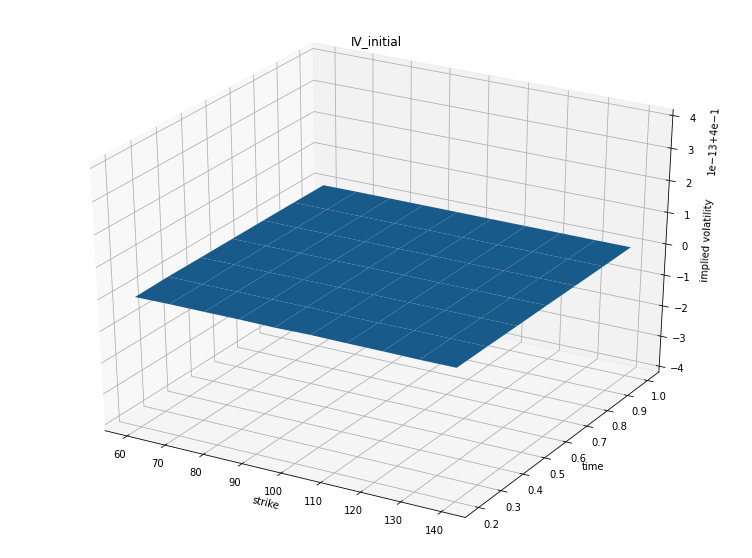

In [8]:
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(*np.meshgrid(K_grid, T_grid), implied_volatilities)
ax2.set_title('IV_initial')
ax2.set_xlabel('strike')
ax2.set_ylabel('time')
ax2.set_zlabel('implied volatility')
# ax2.set_zlim(0.0, 0.5)
#ax2.view_init(-140, 100)

plt.show()

# Plot extended iv 

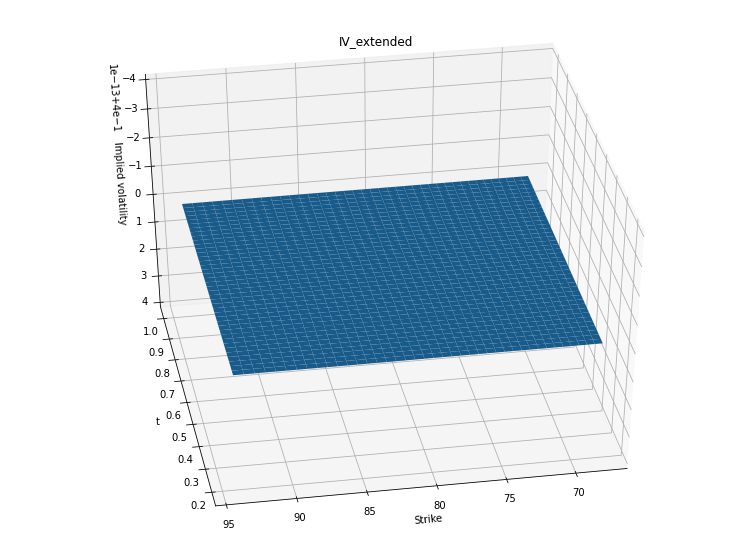

In [9]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(K_extended, t_extended, theta)
ax2.set_title('IV_extended')
ax2.set_xlabel('Strike')
ax2.set_ylabel('t')
ax2.set_zlabel('Implied volatility')
# ax2.set_zlim(0.0, 0.5)
ax2.view_init(-140, 100)

plt.show()

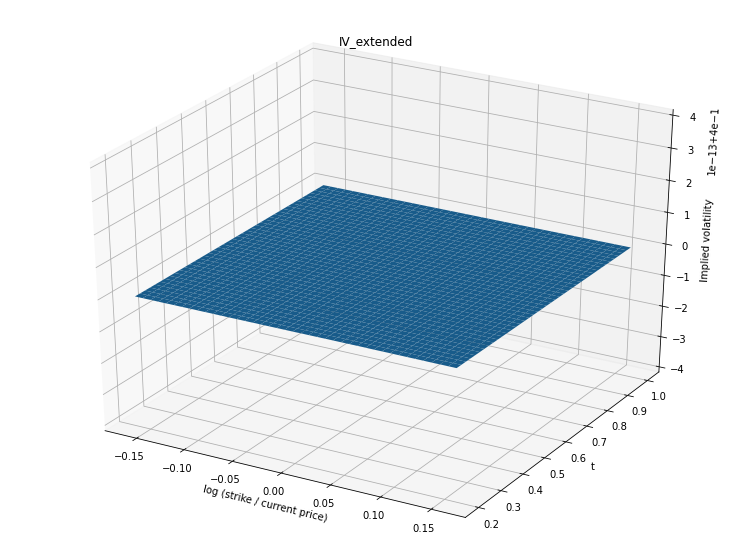

In [10]:
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(y_extended, t_extended, theta)
ax2.set_title('IV_extended')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('t')
ax2.set_zlabel('Implied volatility')
# ax2.set_zlim(0.0, 0.5)
#ax2.view_init(-140, 100)

plt.show()

# Plot local vol obtained

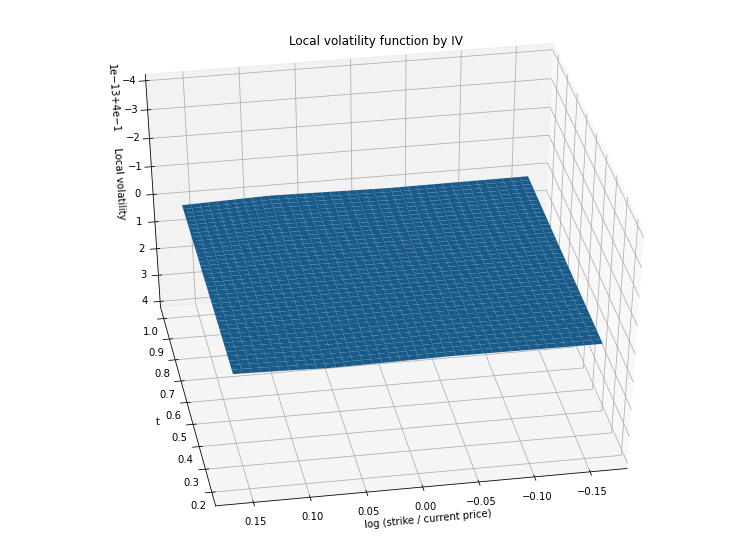

In [11]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(y_extended, t_extended, loc_vol)
ax2.set_title('Local volatility function by IV')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('t')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)
ax2.view_init(-140, 100)

plt.show()

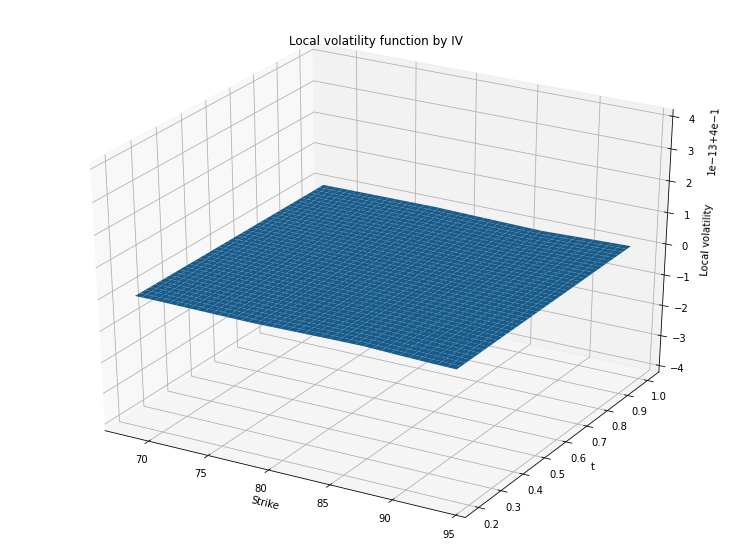

In [12]:
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(K_extended, t_extended, loc_vol)
ax2.set_title('Local volatility function by IV')
ax2.set_xlabel('Strike')
ax2.set_ylabel('t')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)
#ax2.view_init(-140, 100)

plt.show()

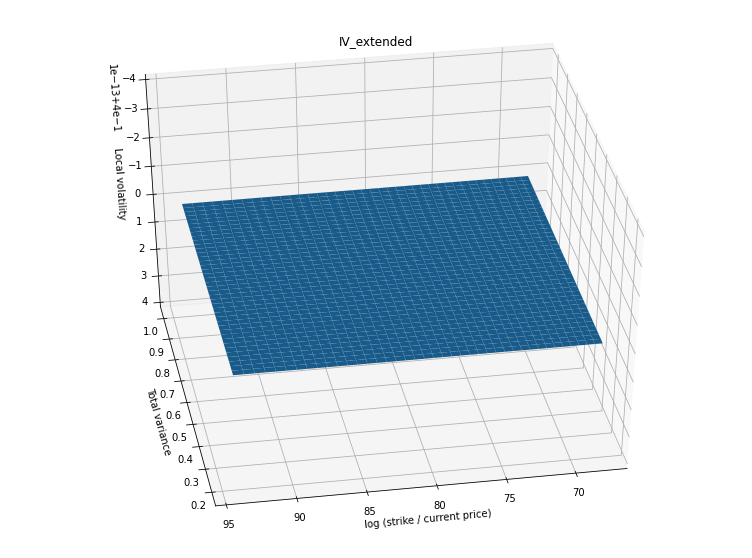

In [13]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(K_extended, t_extended, theta)
ax2.set_title('IV_extended')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('Total variance')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)
ax2.view_init(-140, 100)

plt.show()

# Solve PDE by implicit scheme

# $V_t + (r - q - \frac{1}{2} \sigma^2)V_x + \dfrac{1}{2} \sigma^2 V_{xx} = rV$, $\;\;\;\nu := r - q - \dfrac{1}{2} \sigma^2$

$\dfrac{V^{i}_j - V^{i - 1}_j}{\tau} + \nu^{i - 1}_j \dfrac{V^{i - 1}_{j + 1} - V^{i - 1}_{j - 1}}{2 h} + \dfrac{1}{2} (\sigma^2)^{i - 1}_j \dfrac{V^{i - 1}_{j - 1} - 2 V^{i - 1}_j + V^{i - 1}_{j + 1}}{h^2} = r V^{i - 1}_j$

$\left(-\dfrac{\nu^{i - 1}_j}{2 h} + \dfrac{1}{2 h^2} (\sigma^2)^{i - 1}_j \right)V^{i - 1}_{j - 1} + \left(-\dfrac{1}{\tau} - \dfrac{1}{h^2} (\sigma^2)^{i - 1}_j - r\right) V^{i - 1}_j + \left(\dfrac{\nu^{i - 1}_j}{2 h} + \dfrac{1}{2 h^2} (\sigma^2)^{i - 1}_j \right) V^{i - 1}_{j + 1} = -\dfrac{1}{\tau} V^i_j$

$\left(\dfrac{\tau \nu^{i - 1}_j}{2 h} - \dfrac{\tau}{2 h^2} (\sigma^2)^{i - 1}_j \right)V^{i - 1}_{j - 1} + \left(1 + \dfrac{\tau}{h^2} (\sigma^2)^{i - 1}_j + r\tau \right) V^{i - 1}_j + \left(-\dfrac{\tau \nu^{i - 1}_j}{2 h} - \dfrac{\tau}{2 h^2} (\sigma^2)^{i - 1}_j \right) V^{i - 1}_{j + 1} = V^i_j$

$V^i_0 - V^i_1 = 0, \;\;\; V^i_{M} - V^i_{M - 1} = S[M] - S[M - 1], \;\;\; V^N_j = (S[j] - K)^+$

In [14]:
def progonka_final(c, d, e, b):
    """
    Solves the following system of linear equations (w.r.t. x = (x[0], x[1], ..., x[n - 1])):

    d[0] * x[0] + e[0] * x[1] = b[0],
    c[0] * x[0] + d[1] * x[1] + e[1] * x[2] = b[1],
    ...
    c[i - 1] * x[i - 1] + d[i] * x[i] + e[i] * x[i + 1] = b[i],
    ...
    c[n - 3] * x[n - 3] + d[n - 2] * x[n - 2] + e[n - 2] * x[n - 1] = b[n - 2],
    c[n - 2] * x[n - 2] + d[n - 1] * x[n - 1] = b[n - 1]

    """
    n = len(b)
    alpha, beta = np.zeros(n - 1), np.zeros(n - 1)
    alpha[0], beta[0] = -e[0] / d[0], b[0] / d[0]
    
    for i in range(1, n - 1):
        alpha[i] = -e[i] / (d[i] + c[i - 1] * alpha[i - 1])
        beta[i] = (-c[i - 1] * beta[i - 1] + b[i]) / (d[i] + c[i - 1] * alpha[i - 1])
        
    ans = np.zeros(n)
    ans[-1] = (-c[-1] * beta[-1] + b[-1]) / (d[-1] + c[-1] * alpha[-1])
    
    for i in range(n - 2, -1, -1):
        ans[i] = ans[i + 1] * alpha[i] + beta[i]
        
    return ans

In [15]:
def get_call_option_price_implicit_scheme(K, loc_vol, K_extended, T_extended, N = 500):
    """
    Args:
        K: strike, scalar
        loc_vol: local volatility, matrix
        K_extended, T_extended: coordinates, two matrices
    """
    
    S = K_extended[0]
    tau, h = np.max(T_extended) / N, np.log(K_extended[0, 1] / K_extended[0, 0])

    def c(nu, tau, h, sigma):
        return nu / 2 / h - np.square(sigma) / 2 / h / h

    def d(tau, h, sigma, r = 0):
        return 1 / tau + 1 / h / h * np.square(sigma) + r

    def e(nu, tau, h, sigma):
        return -nu / 2 / h - np.square(sigma) / 2 / h / h

    V = np.zeros_like(loc_vol)

    V[-1] = np.maximum(S - K, np.zeros_like(S - K))

    for i in range(N, 0, -1):
        nu = r - 0.5 * (loc_vol[i - 1, 1:-1] ** 2)
        c_current = np.array(list(c(nu, tau, h, loc_vol[i - 1, 1:-1])) + [-1])
        d_current = np.array([1] + list(d(tau, h, loc_vol[i - 1, 1:-1], r)) + [1])
        e_current = np.array([-1] + list(e(nu, tau, h, loc_vol[i - 1, 1:-1])))

        b = np.array([0] + list(V[i, 1:-1] / tau) + [S[-1] - S[-2]])
        V[i - 1] = progonka_final(c_current, d_current, e_current, b)
        
    return V

# Plot obtained call prices

In [16]:
K = 100
T_extended = t_extended 
V = get_call_option_price_implicit_scheme(K, loc_vol, K_extended, T_extended, N)

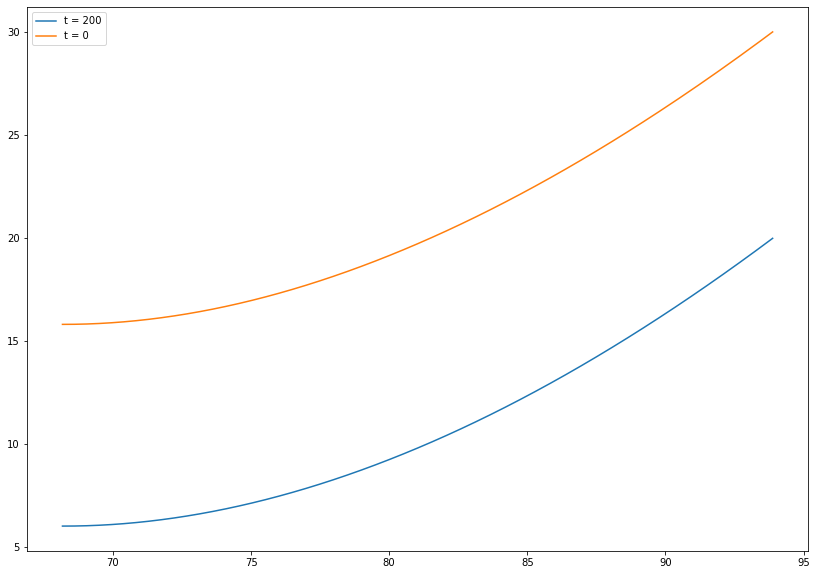

In [17]:
plt.figure(figsize=(14, 10))

#plt.plot(K_extended[0], V[500], label = 't = 500')
#plt.plot(K_extended[0], V[495], label = 't = 495')
#plt.plot(K_extended[0], V[490], label = 't = 490')
#plt.plot(K_extended[0], V[300], label = 't = 300')
plt.plot(K_extended[0], V[99], label = 't = 200')
plt.plot(K_extended[0], V[0], label = 't = 0')


plt.legend()
plt.show()

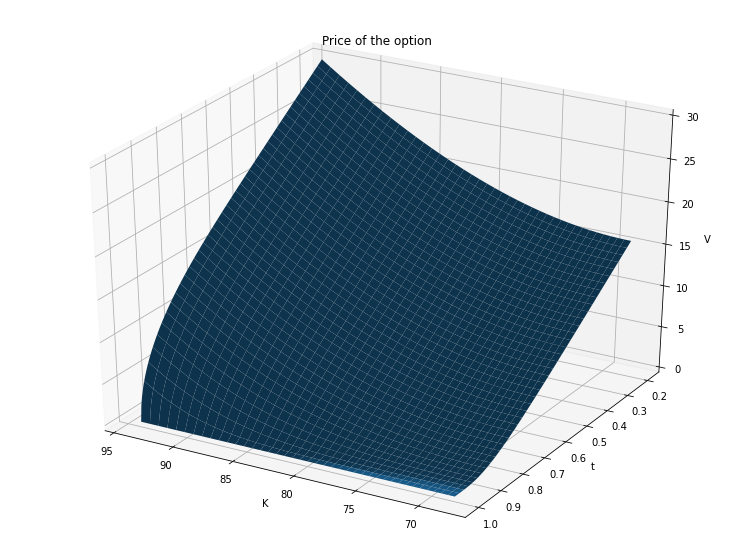

In [18]:
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(K_extended, t_extended, V)
ax2.set_title('Price of the option')
ax2.set_xlabel('K')
ax2.set_ylabel('t')
ax2.set_zlabel('V')
# ax2.set_zlim(0.0, 0.5)
ax2.view_init(30, 120)

plt.show()

# LV хеджинг с перекалибровкой в БШ

In [19]:
def simulate_stock_prices_BS(initial_price, t, paths, steps, r, sigma = 0.4):
    mybsch = blackscholes.BlackScholes(s=initial_price, sigma=0.4, r=r)
    
    return mybsch.simulate(t, steps, paths)

In [20]:
def delta_function_LV(stock_price, S_grid, V):
    # дельта в этом случае - это производная
    # интерполяция - кубические сплайн
    # экстраполяция линейная
    
    #print('S_grid.shape', S_grid.shape)
    #print('V.shape', V.shape)
    spline = CubicSpline(S_grid, V, bc_type='natural')
    if (stock_price > S_grid.max()):
        delta = spline.derivative(nu=1)(S_grid.max())
    if (stock_price < S_grid.min()):
        delta = spline.derivative(nu=1)(S_grid.min())
    if (stock_price >= S_grid.min()) & (stock_price <= S_grid.max()):
        delta = spline.derivative(nu=1)(stock_price)
        
    return delta

In [21]:
def recount_V(T_grid, K_grid, i, s_curr, N, r, gamma=1):
    
    #myheston = heston.Heston(s=s_curr, v=1, kappa=1, theta=0.4, sigma=0.4, rho=0.5, r=r)
    #call_prices = myheston.call_price(T_grid.reshape(-1, 1), K_grid)
    #implied_volatilities = myheston.iv(T_grid.reshape(-1, 1), K_grid)
    
    mybsch = blackscholes.BlackScholes(s=s_curr, sigma=0.4, r=r)  # добавила
    call_prices = mybsch.call_price(T_grid.reshape(-1, 1), K_grid)
    implied_volatilities = mybsch.call_iv(call_prices, T_grid.reshape(-1, 1), K_grid)

    lv = LocalVolatility(r, s_curr)
    
    lv.calibrate(implied_volatilities, K_grid, T_grid, N, gamma)
    
    y_extended, t_extended, loc_vol = *lv.get_extended_grid(), lv.get_local_volatility()
    #print('t_ex', t_extended.shape)
    K_extended = np.exp(y_extended) * s_curr
    #print(shape(implied_volatilities) == shape(K_grid) == shape(T_grid)) 
    V = get_call_option_price_implicit_scheme(K, loc_vol, K_extended, t_extended, N)
    #print(V[0])
    return V[0]

In [22]:
def hedge_LV_BS_perecalibrovka(T, K, initial_price, S_grid, times, V, T_grid, K_grid, paths, steps, N=100, sigma = 0.4, r=0.): 
    
    money_account = np.zeros((steps+1, paths))
    #stock_prices = simulate_stock_prices_heston(initial_price, T, paths, steps, v, kappa, theta, sigma, rho, r)
    stock_prices = simulate_stock_prices_BS(initial_price, T, paths, steps, r, sigma = 0.4)
    pnl = np.full(paths, 0.)
    
    delta = delta_function_LV(initial_price, S_grid[0], V[0])
    delta_arr = np.full((steps, paths), delta)
    
    C = blackscholes.BlackScholes(s=initial_price, sigma=sigma, r=r).call_price(T, K)
   
    money_account[0, :] = C - delta * stock_prices[0, :]
    N = len(times) - 1
    
    for i in range(paths):
        for j in tqdm(range(1, steps)):
            V = recount_V(T_grid + times[j], K_grid, j, stock_prices[j, i], N, r, gamma=1)
            delta_arr[j, i] = delta_function_LV(stock_prices[j, i], S_grid[0], V)
            
            money_account[j, i] = money_account[j-1, i] * np.exp(r*(times[j] - times[j-1])) + (delta_arr[j-1, i] - delta_arr[j, i]) * stock_prices[j, i]
    
        money_account[steps, i] = money_account[steps-1, i] * np.exp(r*(times[steps] - times[steps-1])) + delta_arr[steps-1, i] * stock_prices[steps, i]
        pnl[i] = money_account[steps, i] - max(stock_prices[steps, i] - K, 0.)
        
        if (i<10):
            plt.plot(times, money_account[:, i])
    plt.show()
    
    plt.hist(pnl)
    plt.show()
    
    return np.mean(pnl), np.std(pnl)

In [51]:
K = 100
T_extended = t_extended 
V = get_call_option_price_implicit_scheme(K, loc_vol, K_extended, T_extended, N)

In [52]:
K = 100
initial_price = 80
steps = len(T_extended) - 1
paths = 10
T = 1
times = T_extended
S_grid = K_extended

mean_, std_ = hedge_LV_BS_perecalibrovka(T, K, initial_price, S_grid, times[:, 0], V, T_grid, K_grid, paths, steps)
print('mean pnl =', mean_)
print('std pnl =', std_)

 15%|███████████▊                                                                     | 29/199 [00:06<00:38,  4.44it/s]


KeyboardInterrupt: 

# LV хеджинг в Хестоне без перекалибровки

In [23]:
def delta_function_LV(stock_price, S_grid, V):
    # дельта в этом случае - это производная
    # интерполяция - кубические сплайн
    # экстраполяция линейная
    
    spline = CubicSpline(S_grid, V, bc_type='natural')
    if (stock_price > S_grid.max()):
        delta = spline.derivative(nu=1)(S_grid.max())
    if (stock_price < S_grid.min()):
        delta = spline.derivative(nu=1)(S_grid.min())
    if (stock_price >= S_grid.min()) & (stock_price <= S_grid.max()):
        delta = spline.derivative(nu=1)(stock_price)
        
    return delta

In [24]:
def simulate_stock_prices_heston(initial_price, t, paths, steps, v=0.2, kappa=0.1, theta=0., sigma=0.1, rho=0.8, r=0.):
    myheston = heston.Heston(s=initial_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r)
    
    return myheston.simulate_euler(t, steps, paths)

In [25]:
def count_V_and_locvol(T_grid, K_grid, i, s_curr, N, r, gamma=1):
    
    myheston = heston.Heston(s=s_curr, v=1, kappa=1, theta=0.4, sigma=0.4, rho=0.4, r=r)
    call_prices = myheston.call_price(T_grid.reshape(-1, 1), K_grid)
    implied_volatilities = myheston.iv(T_grid.reshape(-1, 1), K_grid)
    
    #mybsch = blackscholes.BlackScholes(s=s_curr, sigma=0.4, r=r)  # добавила
    #call_prices = mybsch.call_price(T_grid.reshape(-1, 1), K_grid)
    #implied_volatilities = mybsch.call_iv(call_prices, T_grid.reshape(-1, 1), K_grid)

    lv = LocalVolatility(r, s_curr)
    
    lv.calibrate(implied_volatilities, K_grid, T_grid, N, gamma)
    
    y_extended, t_extended, loc_vol = *lv.get_extended_grid(), lv.get_local_volatility()
    #print('t_ex', t_extended.shape)
    K_extended = np.exp(y_extended) * s_curr
    #print(shape(implied_volatilities) == shape(K_grid) == shape(T_grid)) 
    V = get_call_option_price_implicit_scheme(K, loc_vol, K_extended, t_extended, N)
    #print(V[0])
    return V, loc_vol, K_extended, t_extended

In [26]:
def hedge_LV(T, K, initial_price, S_grid, times, V, paths, steps, v=1., kappa=1., theta=0.4, sigma = 0.4, rho=0.4, r=0.): 
    
    money_account = np.zeros((steps+1, paths))
    stock_prices = simulate_stock_prices_heston(initial_price, T, paths, steps, v, kappa, theta, sigma, rho, r)
    #stock_prices = simulate_stock_prices_BS(initial_price, T, paths, steps, r, sigma = 0.4)
    pnl = np.full(paths, 0.)
    
    delta = delta_function_LV(initial_price, S_grid[0], V[0])
    delta_arr = np.full((steps, paths), delta)
    
    C = heston.Heston(s=initial_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r).call_price(T, K)
   
    money_account[0, :] = C - delta * stock_prices[0, :]
    
    for i in tqdm(range(paths)):
        for j in range(1, steps):
            delta_arr[j, i] = delta_function_LV(stock_prices[j, i], S_grid[0], V[j])
            
            money_account[j, i] = money_account[j-1, i] * np.exp(r*(times[j] - times[j-1])) + (delta_arr[j-1, i] - delta_arr[j, i]) * stock_prices[j, i]
    
        money_account[steps, i] = money_account[steps-1, i] * np.exp(r*(times[steps] - times[steps-1])) + delta_arr[steps-1, i] * stock_prices[steps, i]
        pnl[i] = money_account[steps, i] - max(stock_prices[steps, i] - K, 0.)
        money_account[steps, i] = pnl[i]
        
        if (i%10==0):
            plt.plot(times, money_account[:, i])
    plt.show()
    
    plt.hist(pnl, density = 'True')
    plt.title('LV hedging in Heston world')
    plt.show()
    
    return np.mean(pnl), np.std(pnl)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.92it/s]


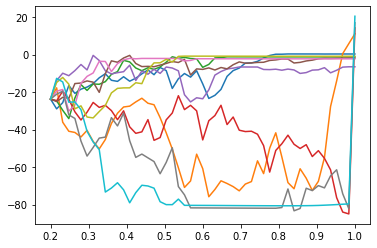

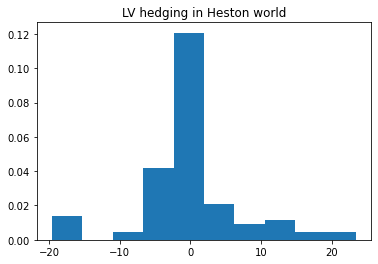

mean pnl = -0.0065803690984241395
std pnl = 7.153173474489273


In [30]:
N = 50
K = 100
initial_price = 70
#steps = len(T_extended) - 1
paths = 100
T = 1

V, loc_vol, S_grid, times = count_V_and_locvol(T_grid, K_grid, 0, initial_price, N, r, gamma=1)
steps = len(times) - 1
mean_, std_ = hedge_LV(T, K, initial_price, S_grid, times[:, 0], V, paths, steps)
print('mean pnl =', mean_)
print('std pnl =', std_)

# БШ хеджинг в Хестоне с рекалибровкой

In [31]:
def delta_function_BS(stock_price, T, t, K, v=0.2, kappa=0.1, theta=0., sigma=0.1, rho=0.8, r=0.):
    # дельта в этом случае - это производная
    
    market = heston.Heston(s=stock_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r)  # считаем, что рынок - Heston
    V =  market.call_price(T - t, K)      # T - t - время до экспирации
    volatility = market.iv(T - t, K)
    #volatility = implied_volatility(V, stock_price, K, T-t, r, 'c')
    #volatility = blackscholes_t10.call_iv(s=stock_price, r=r, c=V, t=np.asarray(T - t), k=K)
    #print('volatility = ', volatility)
    
    d1 = (np.log(stock_price/K) + (r + 0.5*volatility**2)*(T-t) ) / (volatility * np.sqrt(T - t))
    delta = sps.norm.cdf(d1)
    
    #delta_call = delta = mybsch.call_delta(T-t, K)
    #print(delta - delta_call)
    
    return delta

In [32]:
def simulate_stock_prices_heston(initial_price, t, paths, steps, v=0.2, kappa=0.1, theta=0., sigma=0.1, rho=0.8, r=0.):
    myheston = heston.Heston(s=initial_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r)
    
    return myheston.simulate_euler(t, steps, paths)

In [41]:
def hedge_BS(T, K, initial_price, times, paths, steps, v=0.2, kappa=0.1, theta=0., sigma=0.1, rho=0.8, r=0.): # для нескольких путей paths, steps
    
    money_account = np.zeros((steps+1, paths))
    stock_prices = simulate_stock_prices_heston(initial_price, T, paths, steps)
    pnl = np.full(paths, 0.)
    
    delta = delta_function_BS(initial_price, T, 0, K, r)
    delta_arr = np.full((steps, paths), delta)
    
    C = heston.Heston(s=initial_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r).call_price(T, K)
   
    money_account[0, :] = C - delta * stock_prices[0, :]
    
    for i in tqdm(range(paths)):
        for j in range(1, steps):
            delta_arr[j, i] = delta_function_BS(stock_prices[j, i], T, times[j], K)
            
            money_account[j, i] = money_account[j-1, i] * np.exp(r*(times[j] - times[j-1])) + (delta_arr[j-1, i] - delta_arr[j, i]) * stock_prices[j, i]
    
        money_account[steps, i] = money_account[steps-1, i] * np.exp(r*(T - times[steps-1])) + delta_arr[steps-1, i] * stock_prices[steps, i]
        pnl[i] = money_account[steps, i] - max(stock_prices[steps, i] - K, 0.)
        money_account[steps, i] = pnl[i]
        
        if (i%10 == 0):
            plt.plot(times, money_account[:, i])
    plt.show()
    
    plt.hist(pnl, density = True)
    plt.title('BS hedging in Heston world')
    plt.show()
    
    return np.mean(pnl), np.std(pnl)
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]


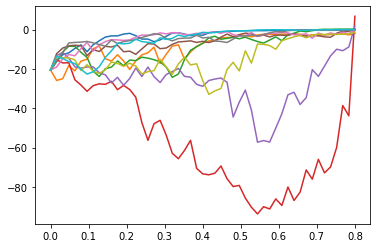

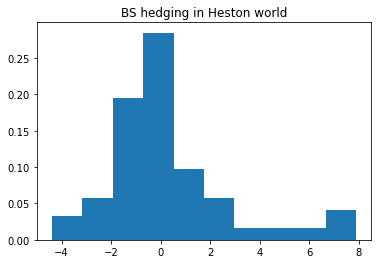

mean pnl = 0.303634782369829
std pnl = 2.4312512789288587


In [43]:
K = 100
initial_price = 70
steps = 50
paths = 100
T = 1
times = np.linspace(0., T-0.2, steps+1)

mean_, std_ = hedge_BS(T, K, initial_price, times, paths, steps)
print('mean pnl =', mean_)
print('std pnl =', std_)

()

# БШ хеджинг в Хестоне без рекалибровки

In [44]:
def delta_function_BS_and_vol(stock_price, T, t, K, volatility, v=0.2, kappa=0.1, theta=0., sigma=0.1, rho=0.8, r=0.):
    # дельта в этом случае - это производная
    
    #market = heston.Heston(s=stock_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r)  # считаем, что рынок - Heston
    #V =  market.call_price(T - t, K)      # T - t - время до экспирации
    #volatility = market.iv(T - t, K)
    #volatility = implied_volatility(V, stock_price, K, T-t, r, 'c')
    #volatility = blackscholes_t10.call_iv(s=stock_price, r=r, c=V, t=np.asarray(T - t), k=K)
    #print('volatility = ', volatility)
    
    d1 = (np.log(stock_price/K) + (r + 0.5*volatility**2)*(T-t) ) / (volatility * np.sqrt(T - t))
    delta = sps.norm.cdf(d1)
    
    #delta_call = delta = mybsch.call_delta(T-t, K)
    #print(delta - delta_call)
    
    return delta

In [46]:
def hedge_BS_without_rec(T, K, initial_price, times, paths, steps, v=0.2, kappa=0.1, theta=0., sigma=0.1, rho=0.8, r=0.): # для нескольких путей paths, steps
    
    money_account = np.zeros((steps+1, paths))
    stock_prices = simulate_stock_prices_heston(initial_price, T, paths, steps)
    pnl = np.full(paths, 0.)
    
    market = heston.Heston(s=initial_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r)  # считаем, что рынок - Heston
    V =  market.call_price(T, K)      # T - t - время до экспирации
    volatility = market.iv(T, K)
    
    d1 = (np.log(initial_price/K) + (r + 0.5*volatility**2)*(T) ) / (volatility * np.sqrt(T))
    delta = sps.norm.cdf(d1)
    
    delta_arr = np.full((steps, paths), delta)
    
    C = heston.Heston(s=initial_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r).call_price(T, K)
   
    money_account[0, :] = C - delta * stock_prices[0, :]
    
    for i in tqdm(range(paths)):
        for j in range(1, steps):
            delta_arr[j, i] = delta_function_BS_and_vol(stock_prices[j, i], T, times[j], K, volatility)
            
            money_account[j, i] = money_account[j-1, i] * np.exp(r*(times[j] - times[j-1])) + (delta_arr[j-1, i] - delta_arr[j, i]) * stock_prices[j, i]
    
        money_account[steps, i] = money_account[steps-1, i] * np.exp(r*(T - times[steps-1])) + delta_arr[steps-1, i] * stock_prices[steps, i]
        pnl[i] = money_account[steps, i] - max(stock_prices[steps, i] - K, 0.)
        money_account[steps, i] = pnl[i]
        
        if (i%10 == 0):
            plt.plot(times, money_account[:, i])
    plt.show()
    
    plt.hist(pnl, density = True)
    plt.title('BS hedging in Heston world')
    plt.show()
    
    return np.mean(pnl), np.std(pnl)
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.10it/s]


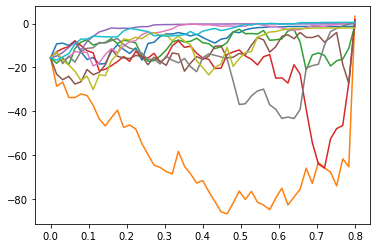

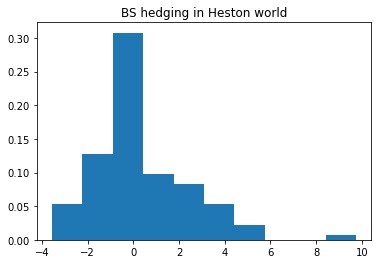

mean pnl = 0.36375020240772116
std pnl = 2.121107771782777


In [48]:
K = 100
initial_price = 70
steps = 50
paths = 100
T = 1
times = np.linspace(0., T-0.2, steps+1)

mean_, std_ = hedge_BS_without_rec(T, K, initial_price, times, paths, steps)
print('mean pnl =', mean_)
print('std pnl =', std_)

In [217]:
def get_mean_std_for_diff_strikes(strikes, initial_price, paths, T, T_grid, K_grid, N):
    n = len(strikes)
    
    means_bs = np.zeros(n)
    stds_bs = np.zeros(n)
    means_lv = np.zeros(n)
    stds_lv = np.zeros(n)
    
    for i in range(n):
        K = strikes[i]
        V, loc_vol, S_grid, times = count_V_and_locvol(T_grid, K_grid, 0, initial_price, N, r, gamma=1)
        steps = len(times) - 1
        mean_lv, std_lv = hedge_LV(T, K, initial_price, S_grid, times[:, 0], V, paths, steps)
    
        means_lv[i] = mean_lv
        stds_lv[i] = std_lv
        
        mean_bs, std_bs = hedge_BS_without_rec(T, K, initial_price, times[:, 0], paths, steps)
        
        means_bs[i] = mean_bs
        stds_bs[i] = std_bs
     
    plt.figure(figsize = (15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(strikes, means_bs, label='BS_mean', color = '#5c53a5', linewidth = 5)
    plt.plot(strikes, means_lv, label='LV_mean', color = '#fbe6c5', linewidth = 5)
    plt.ylabel('Mean')
    plt.xlabel('Strikes')
    plt.title('Mean', {'fontsize' : 27})
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(strikes, stds_bs, label='BS_std', color = '#5c53a5', linewidth = 5)
    plt.plot(strikes, stds_lv, label='LV_std', color = '#fbe6c5', linewidth = 5)
    plt.ylabel('Std')
    plt.xlabel('Strikes')
    plt.title('Std', {'fontsize' : 27})
    plt.legend()
    
    plt.show()
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.65it/s]


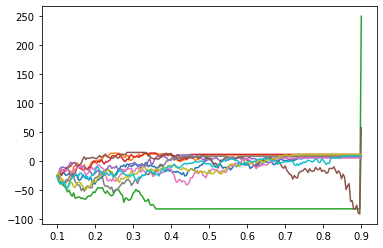

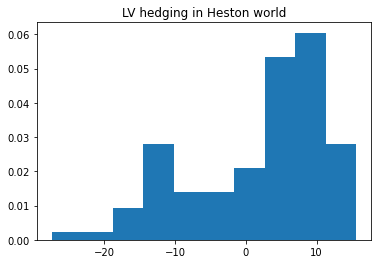

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.39it/s]


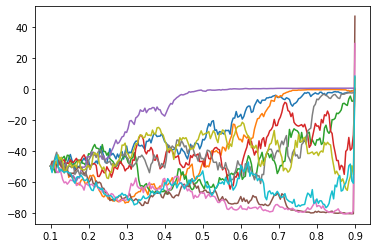

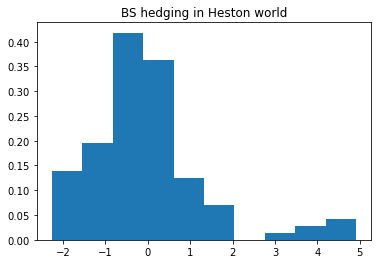

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.19it/s]


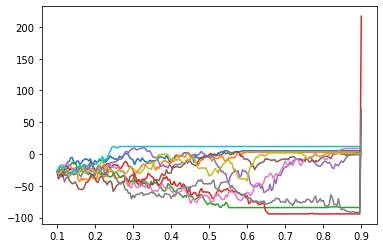

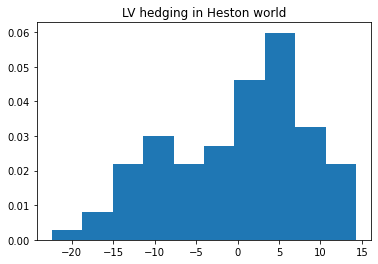

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.65it/s]


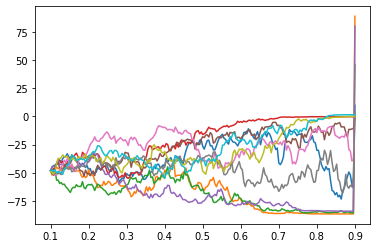

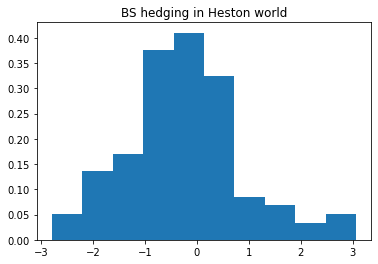

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.78it/s]


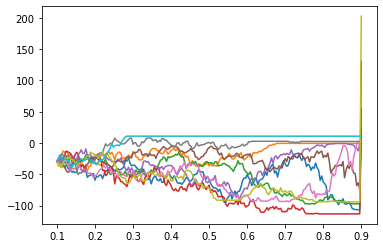

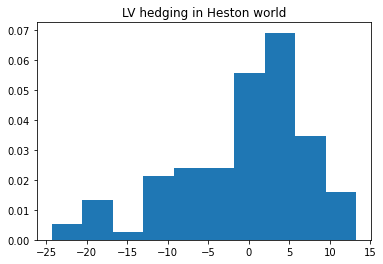

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.01it/s]


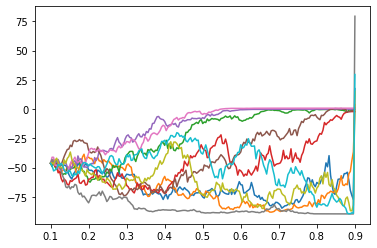

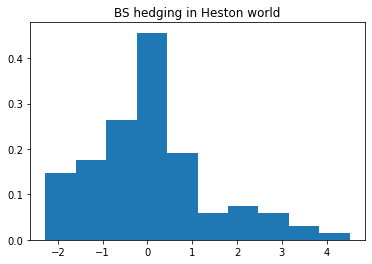

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.15it/s]


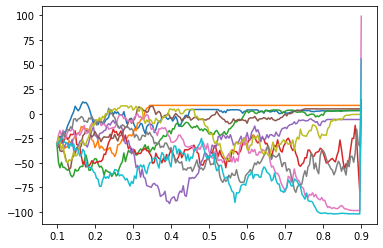

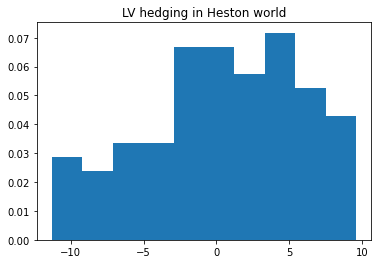

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.74it/s]


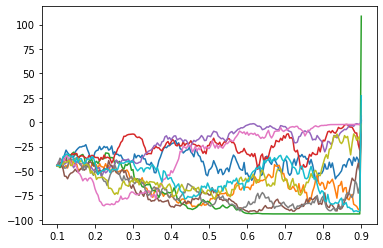

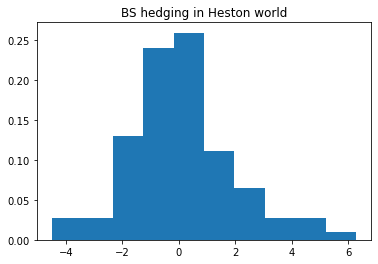

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.15it/s]


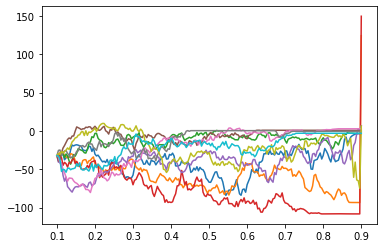

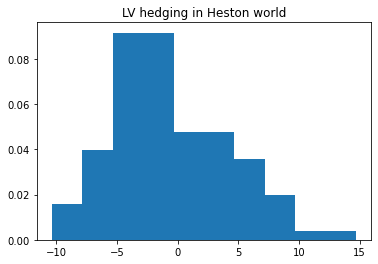

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.43it/s]


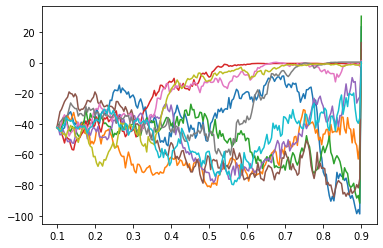

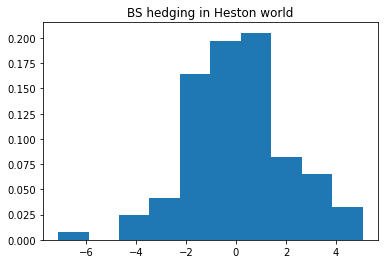

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.23it/s]


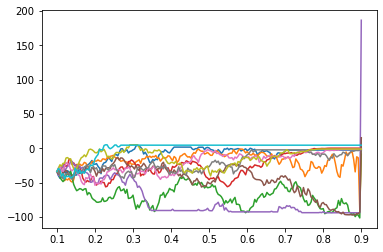

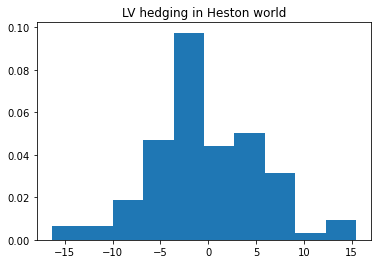

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.09it/s]


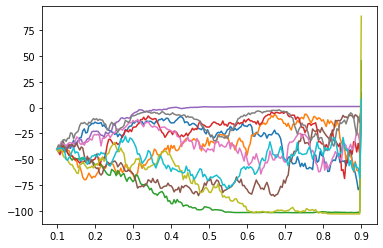

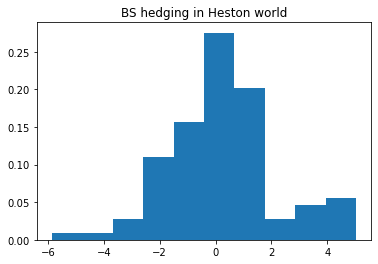

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.86it/s]


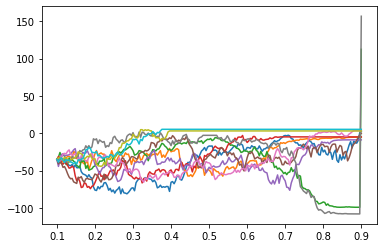

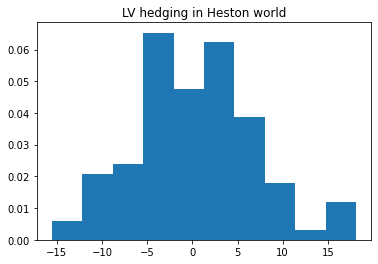

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.33it/s]


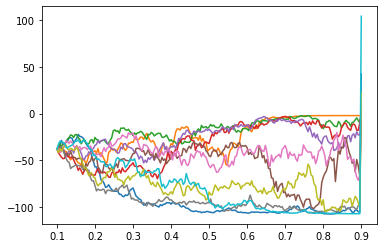

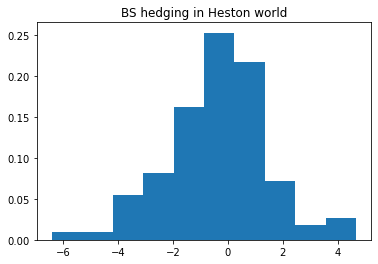

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.37it/s]


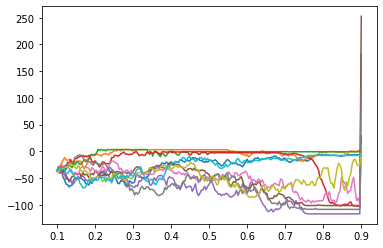

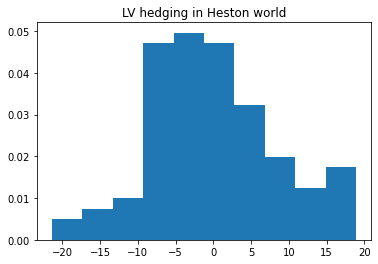

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.01it/s]


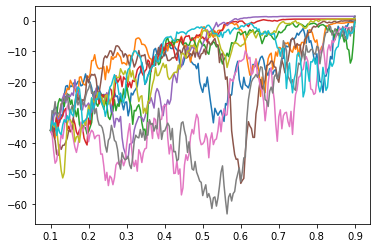

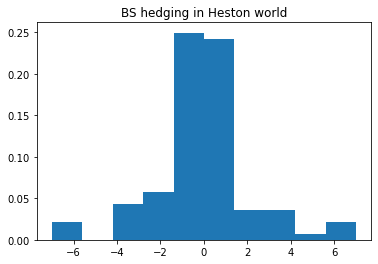

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.40it/s]


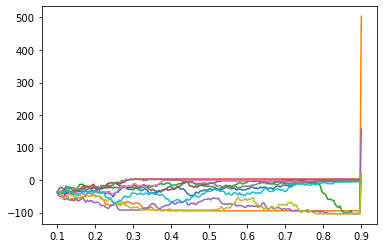

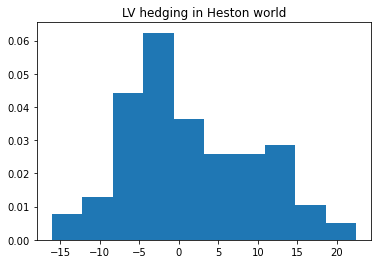

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.75it/s]


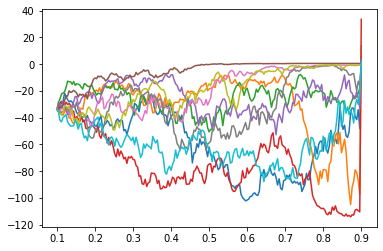

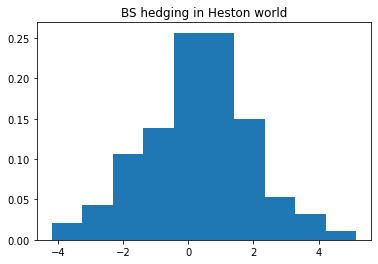

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.20it/s]


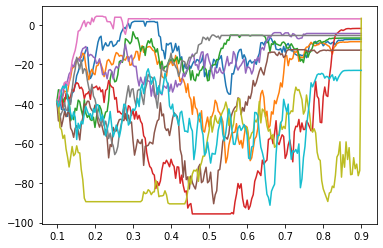

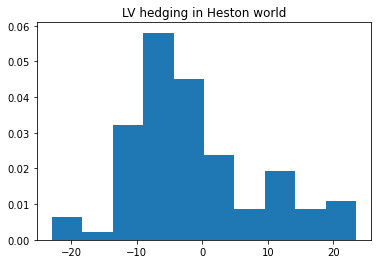

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.46it/s]


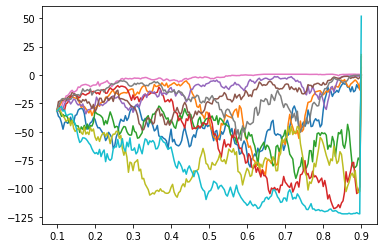

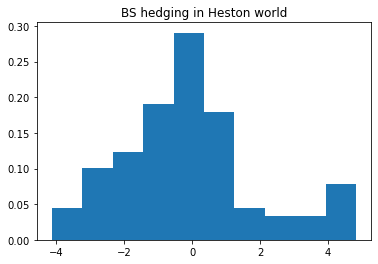

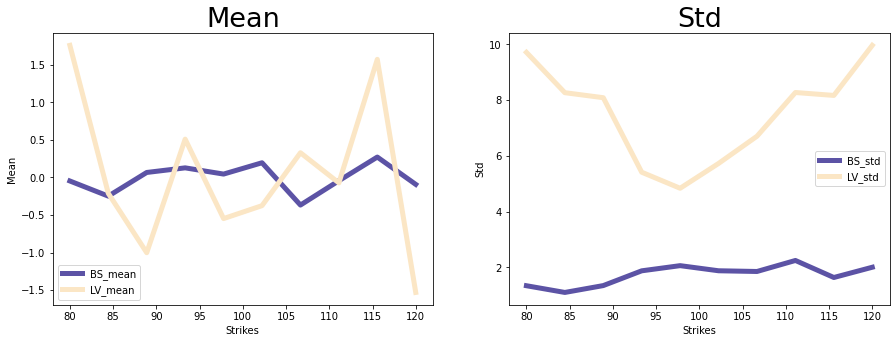

In [218]:
strikes = np.linspace(80, 120, 10)
initial_price = 100
paths = 100
T = 1.
T_grid = np.linspace(0.1, 0.9, 7)
K_grid = np.linspace(60, 140, 10)
N = 200

get_mean_std_for_diff_strikes(strikes, initial_price, paths, T, T_grid, K_grid, N)

# БШ хеджинг в БШ

In [27]:
def simulate_stock_prices_BS(initial_price, t, paths, steps, r, sigma = 0.4):
    mybsch = blackscholes.BlackScholes(s=initial_price, sigma=0.4, r=r)
    
    return mybsch.simulate(t, steps, paths)

In [28]:
def hedge_BS(T, K, initial_price, times, paths, steps, r = 0., sigma = 0.4): # для нескольких путей paths, steps
    
    money_account = np.zeros((steps+1, paths))
    stock_prices = simulate_stock_prices_BS(initial_price, T, paths, steps, r, sigma = 0.4)
    pnl = np.full(paths, 0.)
    
    delta = delta_function_BS(initial_price, T, 0, K, r)
    delta_arr = np.full((steps, paths), delta)
    
    C = blackscholes.BlackScholes(s=initial_price, sigma=sigma, r=r).call_price(T, K)
   
    money_account[0, :] = C - delta * stock_prices[0, :]
    
    for i in tqdm(range(paths)):
        for j in range(1, steps):
            delta_arr[j, i] = delta_function_BS(stock_prices[j, i], T, times[j], K, r)
            
            money_account[j, i] = money_account[j-1, i] * np.exp(r*(times[j] - times[j-1])) + (delta_arr[j-1, i] - delta_arr[j, i]) * stock_prices[j, i]
    
        money_account[steps, i] = money_account[steps-1, i] * np.exp(r*(times[steps] - times[steps-1])) + delta_arr[steps-1, i] * stock_prices[steps, i]
        pnl[i] = money_account[steps, i] - max(stock_prices[steps, i] - K, 0.)
        
        if (i%10 == 0):
            plt.plot(times, money_account[:, i])
    plt.show()
    
    plt.hist(pnl)
    plt.show()
    
    return np.mean(pnl), np.std(pnl)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.67it/s]


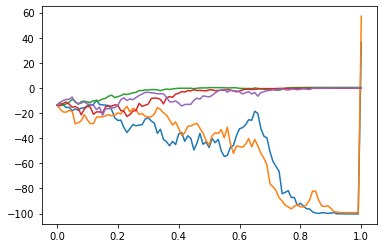

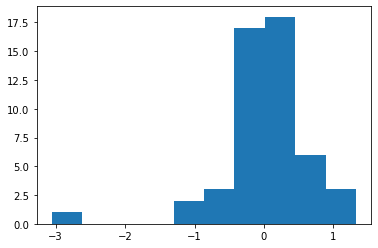

mean pnl = 0.011222356835142394
std pnl = 0.6502983695434869


In [49]:
K = 100
initial_price = 70
steps = 100
paths = 50
T = 1
times = np.linspace(0.2, T, steps+1)

mean_, std_ = hedge_BS(T, K, initial_price, times, paths, steps)
print('mean pnl =', mean_)
print('std pnl =', std_)

# LV хеджинг с перекалибровкой в Heston

In [50]:
def delta_function_LV(stock_price, S_grid, V):
    # дельта в этом случае - это производная
    # интерполяция - кубические сплайн
    # экстраполяция линейная
    
    #print('S_grid.shape', S_grid.shape)
    #print('V.shape', V.shape)
    spline = CubicSpline(S_grid, V, bc_type='natural')
    if (stock_price > S_grid.max()):
        delta = spline.derivative(nu=1)(S_grid.max())
    if (stock_price < S_grid.min()):
        delta = spline.derivative(nu=1)(S_grid.min())
    if (stock_price >= S_grid.min()) & (stock_price <= S_grid.max()):
        delta = spline.derivative(nu=1)(stock_price)
        
    return delta

In [51]:
def count_V_and_locvol(T_grid, K_grid, i, s_curr, N, r, gamma=1):
    
    myheston = heston.Heston(s=s_curr, v=1, kappa=1, theta=0.4, sigma=0.4, rho=0.4, r=r)
    call_prices = myheston.call_price(T_grid.reshape(-1, 1), K_grid)
    implied_volatilities = myheston.iv(T_grid.reshape(-1, 1), K_grid)
    
    #mybsch = blackscholes.BlackScholes(s=s_curr, sigma=0.4, r=r)  # добавила
    #call_prices = mybsch.call_price(T_grid.reshape(-1, 1), K_grid)
    #implied_volatilities = mybsch.call_iv(call_prices, T_grid.reshape(-1, 1), K_grid)

    lv = LocalVolatility(r, s_curr)
    
    lv.calibrate(implied_volatilities, K_grid, T_grid, N, gamma)
    
    y_extended, t_extended, loc_vol = *lv.get_extended_grid(), lv.get_local_volatility()
    #print('t_ex', t_extended.shape)
    K_extended = np.exp(y_extended) * s_curr
    #print(shape(implied_volatilities) == shape(K_grid) == shape(T_grid)) 
    V = get_call_option_price_implicit_scheme(K, loc_vol, K_extended, t_extended, N)
    #print(V[0])
    return V, loc_vol, K_extended, t_extended

In [52]:
def recount_V(T_grid, K_grid, i, s_curr, N, r, gamma=1):
    
    myheston = heston.Heston(s=s_curr, v=1, kappa=1, theta=0.4, sigma=0.4, rho=0.4, r=r)
    call_prices = myheston.call_price(T_grid.reshape(-1, 1), K_grid)
    implied_volatilities = myheston.iv(T_grid.reshape(-1, 1), K_grid)
    
    #mybsch = blackscholes.BlackScholes(s=s_curr, sigma=0.4, r=r)  # добавила
    #call_prices = mybsch.call_price(T_grid.reshape(-1, 1), K_grid)
    #implied_volatilities = mybsch.call_iv(call_prices, T_grid.reshape(-1, 1), K_grid)

    lv = LocalVolatility(r, s_curr)
    
    lv.calibrate(implied_volatilities, K_grid, T_grid, N, gamma)
    
    y_extended, t_extended, loc_vol = *lv.get_extended_grid(), lv.get_local_volatility()
    #print('t_ex', t_extended.shape)
    K_extended = np.exp(y_extended) * s_curr
    #print(shape(implied_volatilities) == shape(K_grid) == shape(T_grid)) 
    V = get_call_option_price_implicit_scheme(K, loc_vol, K_extended, t_extended, N)
    #print(V[0])
    return V[0]

In [53]:
def hedge_LV_BS_recalibrate(T, K, initial_price, S_grid, times, V, T_grid, K_grid, paths, steps, N=100, v=1., kappa=1., theta=0.4, sigma = 0.4, rho=0.4, r=0.): 
    
    money_account = np.zeros((steps+1, paths))
    stock_prices = simulate_stock_prices_heston(initial_price, T, paths, steps, v, kappa, theta, sigma, rho, r)
    #stock_prices = simulate_stock_prices_BS(initial_price, T, paths, steps, r, sigma = 0.4)
    pnl = np.full(paths, 0.)
    
    delta = delta_function_LV(initial_price, S_grid[0], V[0])
    delta_arr = np.full((steps, paths), delta)
    
    C = heston.Heston(s=initial_price, v=v, kappa=kappa, theta=theta, sigma=sigma, rho=rho, r=r).call_price(T, K)
    
    money_account[0, :] = C - delta * stock_prices[0, :]
    N = len(times) - 1
    
    for i in range(paths):
        for j in tqdm(range(1, steps)):
            V = recount_V(T_grid + times[j], K_grid, j, stock_prices[j, i], N, r, gamma=1)
            delta_arr[j, i] = delta_function_LV(stock_prices[j, i], S_grid[0], V)
            
            money_account[j, i] = money_account[j-1, i] * np.exp(r*(times[j] - times[j-1])) + (delta_arr[j-1, i] - delta_arr[j, i]) * stock_prices[j, i]
    
        money_account[steps, i] = money_account[steps-1, i] * np.exp(r*(times[steps] - times[steps-1])) + delta_arr[steps-1, i] * stock_prices[steps, i]
        pnl[i] = money_account[steps, i] - max(stock_prices[steps, i] - K, 0.)
        money_account[steps, i] = pnl[i]
        if (i<10):
            plt.plot(times, money_account[:, i])
    plt.show()
    
    plt.hist(pnl, density = True)
    plt.title('LV hedging in Heston world')
    plt.show()
    
    return np.mean(pnl), np.std(pnl)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.75it/s]


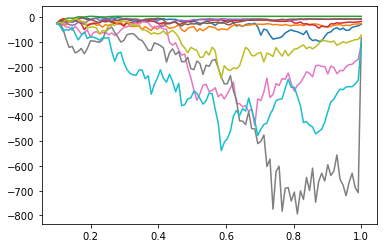

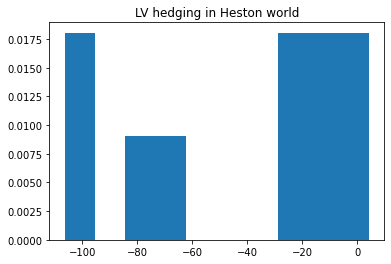

mean pnl = -43.69112978485102
std pnl = 39.4901547718251


In [54]:
N = 100
K = 100
initial_price = 70
#steps = len(T_extended) - 1
paths = 10
T = 1
T_grid = np.linspace(0.1, 1, 7)
K_grid = np.linspace(60, 140, 10)


V, loc_vol, S_grid, times = count_V_and_locvol(T_grid, K_grid, 0, initial_price, N, r, gamma=1)
steps = len(times) - 1
mean_, std_ = hedge_LV_BS_recalibrate(T, K, initial_price, S_grid, times[:, 0], V, T_grid, K_grid, paths, steps, N)
print('mean pnl =', mean_)
print('std pnl =', std_)